In [16]:
using Plots

gr()

# parameters
n = 5
L = 1.0
g = 9.81
dt = 0.003
fps = 30
total_t = 8.0

# starting angles
thetas = zeros(n)
omegas = zeros(n)
thetas[1] = -35*pi/180      # lift the first bob

# pivot points
radius = 0.06
spacing = 2 * radius 
pivot_x = [(i - (n+1)/2) * spacing for i in 1:n]
pivot_y = fill(0.0, n)

# pendulum acceleration
pend_acc(theta) = -(g / L) * sin(theta)

# RK4
function rk4!(thetas, omegas, dt)
    θ1 = copy(thetas)
    ω1 = copy(omegas)
    a1 = pend_acc.(θ1)

    θ2 = θ1 .+ 0.5dt .* ω1
    ω2 = ω1 .+ 0.5dt .* a1
    a2 = pend_acc.(θ2)

    θ3 = θ1 .+ 0.5dt .* ω2
    ω3 = ω1 .+ 0.5dt .* a2
    a3 = pend_acc.(θ3)

    θ4 = θ1 .+ dt .* ω3
    ω4 = ω1 .+ dt .* a3
    a4 = pend_acc.(θ4)

    thetas .+= dt/6 .* (ω1 + 2ω2 + 2ω3 + ω4)
    omegas .+= dt/6 .* (a1 + 2a2 + 2a3 + a4)
end

# position of each bob relative to pivot
function get_positions(thetas)
    [(pivot_x[i] + L*sin(thetas[i]),
      pivot_y[i] - L*cos(thetas[i])) for i in 1:n]
end

# analytic cradle collision rule
# exchange velocities when two bobs approach and their centers cross
function collision_rule!(thetas, omegas)
    pos = get_positions(thetas)
    for i in 1:n-1
        x1, _ = pos[i]
        x2, _ = pos[i+1]
        if x1 > x2  # they crossed
            temp = omegas[i]
            omegas[i] = omegas[i+1]
            omegas[i+1] = temp
        end
    end
end

steps_per_frame = Int(round(1/fps/dt))

anim = @animate for frame in 1:Int(total_t * fps)

    for k in 1:steps_per_frame
        rk4!(thetas, omegas, dt)
        collision_rule!(thetas, omegas)
    end

    pos = get_positions(thetas)
    xs = [p[1] for p in pos]
    ys = [p[2] for p in pos]

    p = plot(
        xlim = (minimum(pivot_x) - 0.5, maximum(pivot_x) + 0.5),
        ylim = (-L - 0.2, 0.2),
        aspect_ratio = 1,
        legend = false,
    )

    scatter!(p, pivot_x, pivot_y, markersize = 3, color = :black)

    for i in 1:n
        plot!(p,
            [pivot_x[i], xs[i]],
            [pivot_y[i], ys[i]],
            lw = 1,
            color = :gray,
        )
        scatter!(p, [xs[i]], [ys[i]], markersize = 20)
    end

    p
end

gif(anim, "cradle.gif", fps=fps)
println("Saved cradle.gif")


Saved cradle.gif


[ Info: Saved animation to /home/jovyan/Julia-Exploration/cradle.gif


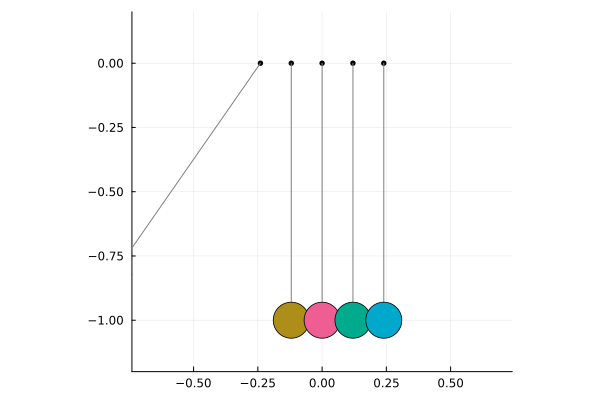

In [17]:
using IJulia
IJulia.display("image/gif", read("cradle.gif"))